# Stochastic quasi-Newton optimization

This is an example IPython notebook showing the usage of the [stochQN](https://www.github.com/david-cortes/stochQN) package on the BibTeX dataset, which can be found under the [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html).

### Parsing the data:

In [1]:
import numpy as np, pandas as pd, re
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import coo_matrix, csr_matrix

def parse_data(file_name, return_wide=True, return_sp=False, convert_sp=False):
    features = list()
    labels = list()
    with open(file_name,'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]",l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$",l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))

    if not return_sp:
        features = pd.DataFrame.from_dict(features).fillna(0).values
    else:
        if convert_sp:
            features = np.array([(i,k,v) for i in range(len(features)) for k,v in features[i].items()])
            features = coo_matrix((features[:,2], (features[:,0].astype('int32'), features[:,1].astype('int32'))))
            features = csr_matrix(features)

    if return_wide:
        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(labels)
        return features, y
    else:
        return features, labels
    
X, Y = parse_data("Bibtex_data.txt", return_wide=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6655, 1836)
(6655, 159)
(740, 1836)
(740, 159)


### Optimizers and parameters:

In [2]:
from stochqn import oLBFGS, adaQN
from sklearn.linear_model.logistic import _multinomial_loss_grad

### Functions for optimization
def grad_fun(w, X, Y, sample_weights=None, reg_param=None):
    if sample_weights is None:
        sample_weights = np.ones(X.shape[0])
    return _multinomial_loss_grad(w, X, Y, reg_param, sample_weights)[1]

def obj_fun(w, X, Y, sample_weights=None, reg_param=None):
    if sample_weights is None:
        sample_weights = np.ones(X.shape[0])
    return _multinomial_loss_grad(w, X, Y, reg_param, sample_weights)[0]

### Random initialization for the weights
np.random.seed(1)
w0 = np.random.normal(size = (X.shape[1] + 1) * Y.shape[1])
w_sgd = w0.copy()
w_rmsprop = w0.copy()

### L2 regularization strength
reg_param = 1e-1

### Shuffling the data
random_order = np.argsort(np.random.random(size = X_train.shape[0]))
X_train = X_train[random_order]
Y_train = Y_train[random_order]

### Step sizes for each optimizer - these haven't been tuned very well
step_size_sgd = 1e-1
step_size_rmsprop = 1e-2
step_size_olbfgs = 1e-2
step_size_adaqn = 1e-1

### Other parameters for RMSProp
reg_rmsprop = 1e-4
w_div_rmsprop = 0.9
sum_grad_sq_rmsprop = np.zeros(w_rmsprop.shape[0])

### Initializing optimizers from this package
adaqn = adaQN(x0=w0.copy(), step_size=step_size_adaqn, grad_fun=grad_fun, obj_fun=obj_fun,
           decr_step_size=None, rmsprop_weight=0.9)

olbfgs = oLBFGS(x0=w0.copy(), step_size=step_size_olbfgs, grad_fun=grad_fun, obj_fun=obj_fun,
           decr_step_size=None)

### Running different optimizers on the same batches of data:

In [3]:
lst_accessed_data_points = list()
lst_valset_loss_sgd = list()
lst_valset_loss_rmsprop = list()
lst_valset_loss_olbfgs = list()
lst_valset_loss_adaqn = list()
test_weights = np.ones(X_test.shape[0])

batch_size = 50
nbatches = int(np.ceil(X_train.shape[0] / batch_size))
for batch in range(nbatches):
    
    ### Data for this batch
    batch_start = batch * batch_size
    batch_end = min(X_train.shape[0], (batch + 1) * batch_size)
    X_batch = X_train[batch_start : batch_end]
    Y_batch = Y_train[batch_start : batch_end]
    s_weigh = np.ones(X_batch.shape[0])
    
    ### Gradients for optimizers outside of this package
    gradient_batch_sgd = grad_fun(w_sgd, X_batch, Y_batch, s_weigh, reg_param)
    gradient_batch_rmsprop = grad_fun(w_rmsprop, X_batch, Y_batch, s_weigh, reg_param)
    
    #### Stochastic gradient descent update
    w_sgd -= step_size_sgd * gradient_batch_sgd
    
    #### RMSProp update
    sum_grad_sq_rmsprop = w_div_rmsprop * sum_grad_sq_rmsprop + (1 - w_div_rmsprop) * gradient_batch_rmsprop**2
    w_rmsprop -= step_size_rmsprop * gradient_batch_rmsprop / np.sqrt(sum_grad_sq_rmsprop + reg_rmsprop)

    ### Stochastic quasi-Newtons
    adaqn.partial_fit(X_batch, Y_batch, s_weigh, additional_kwargs={"reg_param":reg_param})
    olbfgs.partial_fit(X_batch, Y_batch, s_weigh, additional_kwargs={"reg_param":reg_param})
            
    lst_accessed_data_points.append( X_batch.shape[0] )
    lst_valset_loss_sgd.append( obj_fun(w_sgd, X_test, Y_test, test_weights, reg_param) )
    lst_valset_loss_rmsprop.append( obj_fun(w_rmsprop, X_test, Y_test, test_weights, reg_param) )
    lst_valset_loss_adaqn.append( obj_fun(adaqn.x, X_test, Y_test, test_weights, reg_param) )
    lst_valset_loss_olbfgs.append( obj_fun(olbfgs.x, X_test, Y_test, test_weights, reg_param) )

adaQN - at iteration  60: func_increased
adaQN - at iteration 100: func_increased
adaQN - at iteration 120: func_increased


### Plotting the results:

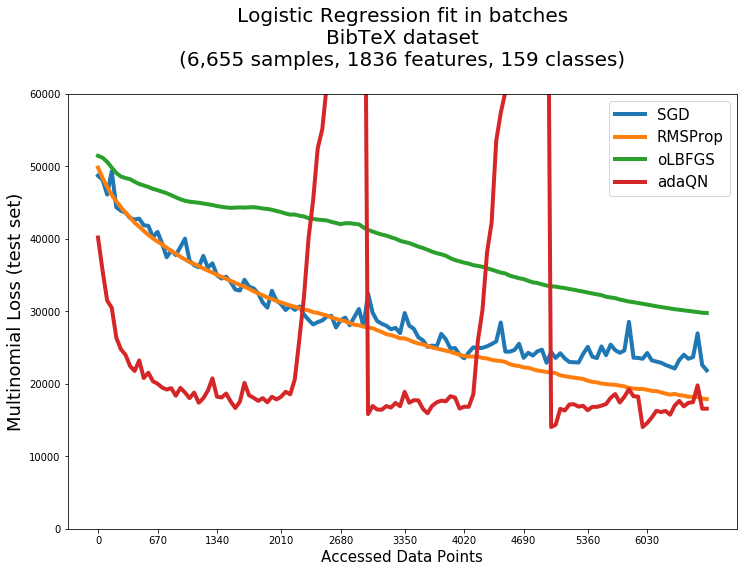

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams

loss_comp = pd.DataFrame({
    "Accessed Data Points" : lst_accessed_data_points,
    "SGD" : lst_valset_loss_sgd,
    "RMSProp" : lst_valset_loss_rmsprop,
    "oLBFGS" : lst_valset_loss_olbfgs,
    "adaQN" : lst_valset_loss_adaqn,
    })

txt_plot = "Logistic Regression fit in batches\nBibTeX dataset\n("
txt_plot += "{:,}".format(X_train.shape[0]) + " samples, " + str(X_train.shape[1]) + " features, "
txt_plot += str(Y.shape[1]) + " classes)\n"

rcParams['figure.figsize'] = 12, 8
lwd = 4
ax = plt.subplot(111)
plt.plot(loss_comp["SGD"], linewidth = lwd)
plt.plot(loss_comp["RMSProp"], linewidth = lwd)
plt.plot(loss_comp["oLBFGS"], linewidth = lwd)
plt.plot(loss_comp["adaQN"], linewidth = lwd)
nticks = 10
tick_scal = loss_comp.shape[0] * batch_size / nticks
plt.xticks([int(i*loss_comp.shape[0]/nticks) for i in range(nticks)], [int(i*tick_scal) for i in range(nticks)])
ax.legend(fancybox=True, prop={'size':15})
plt.ylabel('Multinomial Loss (test set)', size=18)
plt.xlabel('Accessed Data Points', size=15)
plt.title(txt_plot, size=20)
plt.ylim(0, 6 * 10**4)
plt.show()